**Grand X-Ray Slam**: Division B, the second of a 2-part Kaggle hackathon series where data scientists and AI enthusiasts compete to advance medical imaging. In this challenge, you’ll develop AI models to detect 14 thoracic conditions from chest X-rays, tackling real-world clinical complexity. Your work will power Dr HealthAgent by Blue and Gold Healthcare Inc., enhancing global healthcare.

Top performers across both Division B and Division A will also shine on the Grand Slam Leaderboard, sharing an additional $2,500 prize pool.

Name:**Shams Alkhalidy**

# Dataset Description
The Grand X-Ray Slam Division B dataset contains 108,494 chest X-ray images (~139GB) from three major institutions, designed for multi-label classification of 14 thoracic conditions.

This dataset is Part 2 of the ChestDx-MultiInstitution collection. The other half powers Grand X-Ray Slam: Division A.

**Mission**: build AI models for Dr. HealthAgent to detect thoracic conditions and assist radiologists worldwide.

**Files**

train2.csv – Training labels for ~108,494 images.

train2/ – ~108,494 JPG images (e.g., 000100_001_001.jpg).

test1/ – ~47,927 JPG test images.

**Columns in train2.csv**

- Image_Name – X-ray filename (PatientID_Study_View.jpg).
- Patient_ID – Unique anonymized patient identifier
- Study – Groups X-rays from the same clinical visit.
- Sex – Male / Female (may contain NaNs).
- Age – Patient age (may contain NaNs).
- ViewCategory – Frontal or Lateral.
- ViewPosition – AP / PA / LATERAL.
- 
**14 thoracic conditions (0 = absent, 1 = present):**
- Atelectasis
- Cardiomegaly
- Consolidation
- Edema
- Enlarged Cardiomediastinum
- Fracture
- Lung Lesion
- Lung Opacity
- No Finding
- Pleural Effusion
- Pleural Other
- Pneumonia
- Pneumothorax
- Support Devices
  
**What You’re Predicting: You must detect 14 chest conditions:**

1. Heart issues – Cardiomegaly, Enlarged Cardiomediastinum
2. Lung problems – Pneumonia, Pneumothorax, Lung Opacity
3. Fluid-related – Pleural Effusion, Edema
4. Other – Fracture, Support Devices, No Finding

**Data Provenance**

This dataset is a curated merge of multiple public chest X-ray datasets, fully anonymized and preprocessed to ensure no patient overlap between train and test sets.

**Things to Know**

- Images come from different machines and institutions (style variation).
- Rare conditions (e.g., pneumothorax) → imbalanced labels.
- No patient overlap between train and test.
- Some Sex/Age values missing (NaN).
- Multi-label: one X-ray can show several conditions.

**Tips**

1. Pay attention to rare conditions – they’re the toughest.
2. Conditions often co-occur (e.g., edema + effusion).
3. Medical context matters – don’t treat each label as fully independent.

In [1]:
# Imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import random

In [2]:
import os
print(os.listdir("/kaggle/input"))

# Path to competition dataset
data_dir = "/kaggle/input/grand-xray-slam-division-b"
# Check what files are inside
print('Filenames of the data', os.listdir(data_dir))

['grand-xray-slam-division-b', 'iterstrat']
Filenames of the data ['test2', 'sample_submission_2.csv', 'train2.csv', 'train2']


# Load Data

 Each row corresponds to one chest X-ray image.

In [3]:
# Load the training CSV metadata with labels
train = pd.read_csv(f"{data_dir}/train2.csv")

print('Metadata shape:',train.shape)
train.head()

Metadata shape: (108494, 21)


,Image_name,Patient_ID,Study,Sex,Age,ViewCategory,ViewPosition,Atelectasis,Cardiomegaly,Consolidation,...,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,00000003_001_001.jpg,3,1,Male,41.0,Frontal,AP,0,1,0,...,1,0,0,1,0,0,0,0,0,0
1,00000004_001_001.jpg,4,1,Female,20.0,Frontal,PA,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,00000004_001_002.jpg,4,1,Female,20.0,Lateral,Lateral,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,00000006_001_001.jpg,6,1,Female,42.0,Frontal,AP,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,00000010_001_001.jpg,10,1,Female,50.0,Frontal,PA,0,0,0,...,0,0,0,0,1,0,0,0,0,0


# Map images to metdata
map images of Xray to the metadata of labels

In [4]:
# Add full path to each image (new column:filepath )
train["filepath"] = train["Image_name"].apply(lambda x: os.path.join(data_dir, "train2", x))
train.head()

,Image_name,Patient_ID,Study,Sex,Age,ViewCategory,ViewPosition,Atelectasis,Cardiomegaly,Consolidation,...,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices,filepath
0,00000003_001_001.jpg,3,1,Male,41.0,Frontal,AP,0,1,0,...,0,0,1,0,0,0,0,0,0,/kaggle/input/grand-xray-slam-division-b/train...
1,00000004_001_001.jpg,4,1,Female,20.0,Frontal,PA,0,0,0,...,0,0,0,1,0,0,0,0,0,/kaggle/input/grand-xray-slam-division-b/train...
2,00000004_001_002.jpg,4,1,Female,20.0,Lateral,Lateral,0,0,0,...,0,0,0,1,0,0,0,0,0,/kaggle/input/grand-xray-slam-division-b/train...
3,00000006_001_001.jpg,6,1,Female,42.0,Frontal,AP,0,0,0,...,0,0,0,1,0,0,0,0,0,/kaggle/input/grand-xray-slam-division-b/train...
4,00000010_001_001.jpg,10,1,Female,50.0,Frontal,PA,0,0,0,...,0,0,0,1,0,0,0,0,0,/kaggle/input/grand-xray-slam-division-b/train...


# Dataset Summary

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108494 entries, 0 to 108493
Data columns (total 22 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Image_name                  108494 non-null  object 
 1   Patient_ID                  108494 non-null  int64  
 2   Study                       108494 non-null  int64  
 3   Sex                         93829 non-null   object 
 4   Age                         93829 non-null   float64
 5   ViewCategory                108494 non-null  object 
 6   ViewPosition                108494 non-null  object 
 7   Atelectasis                 108494 non-null  int64  
 8   Cardiomegaly                108494 non-null  int64  
 9   Consolidation               108494 non-null  int64  
 10  Edema                       108494 non-null  int64  
 11  Enlarged Cardiomediastinum  108494 non-null  int64  
 12  Fracture                    108494 non-null  int64  
 13  Lung Lesion   

In [6]:
print(train.isna().sum())  #Missing Values

Image_name                        0
Patient_ID                        0
Study                             0
Sex                           14665
Age                           14665
ViewCategory                      0
ViewPosition                      0
Atelectasis                       0
Cardiomegaly                      0
Consolidation                     0
Edema                             0
Enlarged Cardiomediastinum        0
Fracture                          0
Lung Lesion                       0
Lung Opacity                      0
No Finding                        0
Pleural Effusion                  0
Pleural Other                     0
Pneumonia                         0
Pneumothorax                      0
Support Devices                   0
filepath                          0
dtype: int64


In [7]:
total_images = len(train)
total_patients = train['Patient_ID'].nunique()
total_studies = train['Study'].nunique()
print(f"Total Images: {total_images}")
print(f"Total Patients: {total_patients}")
print(f"Total Studies: {total_studies}")

Total Images: 108494
Total Patients: 32077
Total Studies: 184


# Label Prevelance Analysis
Analyze the distribution of the 14 conditions to identify class imbalance

In [8]:
# Class imbalance
label_cols = ['Atelectasis','Cardiomegaly','Consolidation','Edema','Enlarged Cardiomediastinum',
              'Fracture','Lung Lesion','Lung Opacity','No Finding','Pleural Effusion',
              'Pleural Other','Pneumonia','Pneumothorax','Support Devices']
# Calculate counts and percentages for each condition
label_counts = train[label_cols].sum()
label_percentages = (label_counts / total_images * 100).round(2)
prevalence_df = pd.DataFrame({
    'Condition': label_counts.index,
    'Count': label_counts.values,
    'Percent (%)': label_percentages.values
}).sort_values(by='Count', ascending=False)

# Display prevalence table
print("Label Prevalence:")
print(prevalence_df)

Label Prevalence:
                     Condition  Count  Percent (%)
7                 Lung Opacity  49022        45.18
0                  Atelectasis  38613        35.59
4   Enlarged Cardiomediastinum  37566        34.62
13             Support Devices  37385        34.46
1                 Cardiomegaly  34980        32.24
9             Pleural Effusion  34569        31.86
8                   No Finding  34365        31.67
2                Consolidation  29644        27.32
3                        Edema  26567        24.49
5                     Fracture  14578        13.44
11                   Pneumonia  14316        13.20
6                  Lung Lesion  12357        11.39
12                Pneumothorax   8738         8.05
10               Pleural Other   6931         6.39


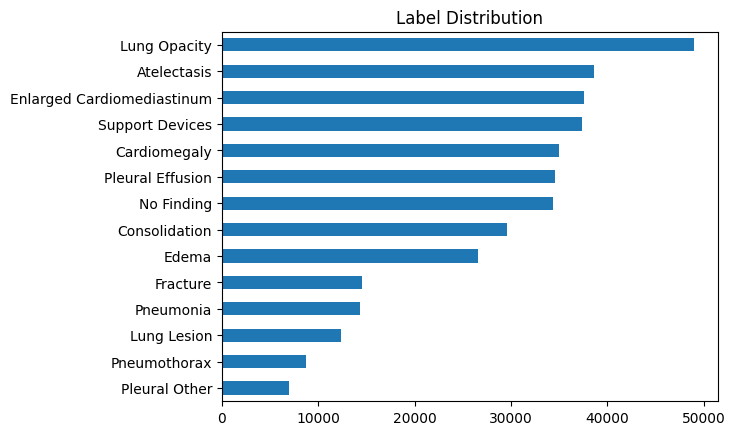

In [9]:
train[label_cols].sum().sort_values().plot(kind="barh")
plt.title('Label Distribution')
plt.show()
# Pleural Other condition is pretty rare and Lung Opacity is common among patients

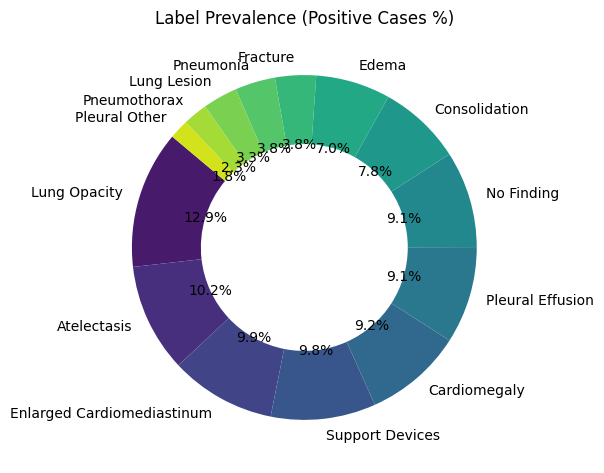

In [10]:
# Donut chart for label percentages
plt.figure(figsize=(6, 6))
colors = sns.color_palette('viridis', len(prevalence_df)) #Generates a list of colors using the viridis colormap from Seaborn.

# prevalence_df['Count'] = number of positive cases per condition
plt.pie(prevalence_df['Count'], labels=prevalence_df['Condition'],
        autopct=lambda pct: f'{pct:.1f}%', startangle=140, colors=colors,
        wedgeprops={'width': 0.4})

plt.title('Label Prevalence (Positive Cases %)')
plt.tight_layout()
plt.savefig('/content/label_percent_donut.jpg')
plt.show()

# Multi-Label Pattens
Examine number of conditions that occur per Xray Image

In [11]:
# calculate number of labels per image
train['label_count'] = train[label_cols].sum(axis=1)      # axis=1 to sum accross columns
multi_labelcount= train['label_count'].value_counts().sort_index()
multi_label_perc = (multi_labelcount/total_images *100).round(2)

# Display mult-label distribution
print('Multi-label distribution')
print(pd.DataFrame({
                    "Number of Labels": multi_labelcount.index,
                    "Count": multi_labelcount.values,
                    "Percentage": multi_label_perc.values
}))

Multi-label distribution
    Number of Labels  Count  Percentage
0                  1  52859       48.72
1                  2   9305        8.58
2                  3   5912        5.45
3                  4   4685        4.32
4                  5   4028        3.71
5                  6   3907        3.60
6                  7   6905        6.36
7                  8  12765       11.77
8                  9   4529        4.17
9                 10   2797        2.58
10                11    706        0.65
11                12     96        0.09


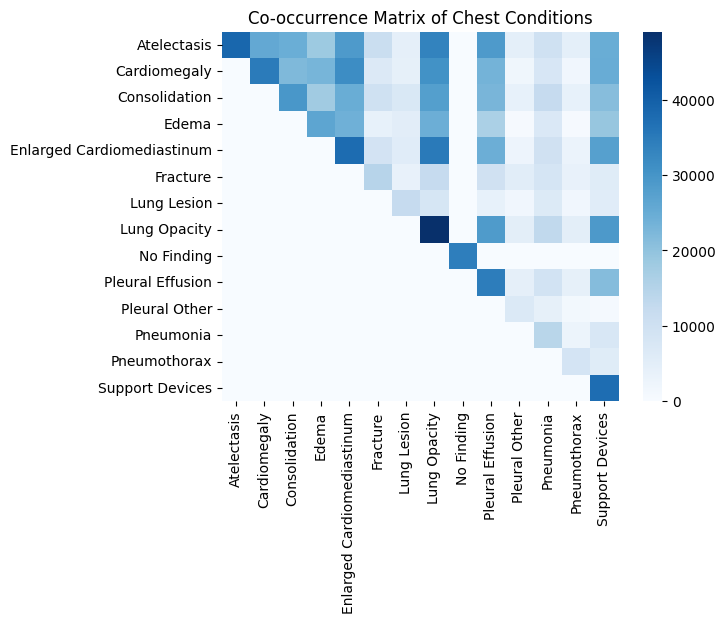

In [12]:
# Co-occurrence matrix → which labels tend to appear together.
# Initialize empty matrix
co_matrix = np.zeros((len(label_cols), len(label_cols)))

# Fill it
for i, col1 in enumerate(label_cols):
    for j, col2 in enumerate(label_cols):
        if i <= j:  # fill upper triangle (matrix is symmetric)
            co_matrix[i, j] = ((train[col1] == 1) & (train[col2] == 1)).sum()

# Convert to DataFrame for nicer display
co_matrix_df = pd.DataFrame(co_matrix, index=label_cols, columns=label_cols)

sns.heatmap(co_matrix_df, annot=False, cmap="Blues")
plt.title("Co-occurrence Matrix of Chest Conditions")
plt.show()
# co_matrix_df

           Type  Count
0  Single Label  52859
1   Multi-Label  55635


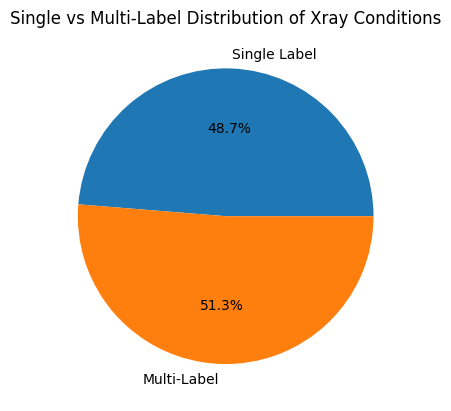

In [13]:
# Visualizing Single label vs Multi-label distribution among X-ray Training data
single_label_count = (train['label_count']==1).sum()
multi_label_count = (train['label_count']>1).sum()

# put into a dataframe
label_dist= pd.DataFrame({'Type':['Single Label','Multi-Label'],
                               'Count': [single_label_count,multi_label_count]})
print(label_dist)

plt.pie(label_dist['Count'], labels = label_dist['Type'], autopct="%1.1f%%")
plt.title('Single vs Multi-Label Distribution of Xray Conditions')
plt.show()

                             Type  Count
0  Single Label(Excl. No Finding)  18494
1   Multi-Label(Excl. No Finding)  55635


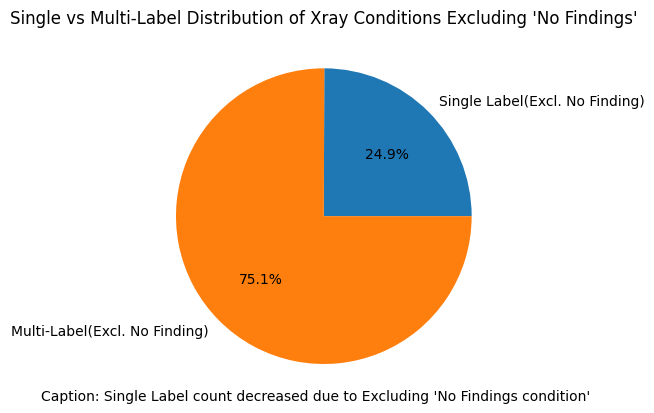

In [14]:
# Display Multi-label Patterns excluding the No Findings Xray conditions
filtered_df = train[(train['label_count'] >=1) & (train['No Finding'] == 0)]

single_label_count = (filtered_df['label_count']==1).sum()
multi_label_count = (filtered_df['label_count']>1).sum()

# put into a dataframe
label_dist= pd.DataFrame({'Type':['Single Label(Excl. No Finding)','Multi-Label(Excl. No Finding)'],
                               'Count': [single_label_count,multi_label_count]})
print(label_dist)

plt.pie(label_dist['Count'], labels = label_dist['Type'], autopct="%1.1f%%")
plt.title("Single vs Multi-Label Distribution of Xray Conditions Excluding 'No Findings'")
plt.figtext(0.5,0.112,"Caption: Single Label count decreased due to Excluding 'No Findings condition'",ha='center')
plt.show()

# Demographic Insights
- Analyze Sex and Age distribution and their relations to conditions

In [15]:
valid_ages = train['Age'].dropna()

valid_age_count = valid_ages[(valid_ages>=0) & (valid_ages<=120)].count()
nan_age_count = train['Age'].isna().sum()
invalid_age_count = valid_ages[(valid_ages<0) | (valid_ages>120)].count()

print(f'Images with Valid age :{valid_age_count}')
print(f'Images with missing age:{nan_age_count}')
print(f'Images with invalid Age:{invalid_age_count}')


Images with Valid age :93829
Images with missing age:14665
Images with invalid Age:0


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


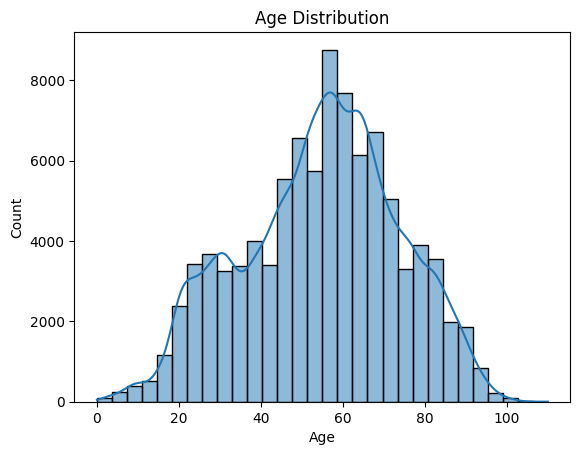

In [16]:
# Demographic Distribution 
# Age
sns.histplot(train['Age'].dropna(), bins=30, kde=True)
plt.title('Age Distribution')
plt.savefig('/content/age_distribution.jpg')
plt.show()
# age distribution looks normal (centered ~55–60)

Distribution among train data of: Sex
Male       54504
Female     39325
Unknown    14665
Name: count, dtype: int64


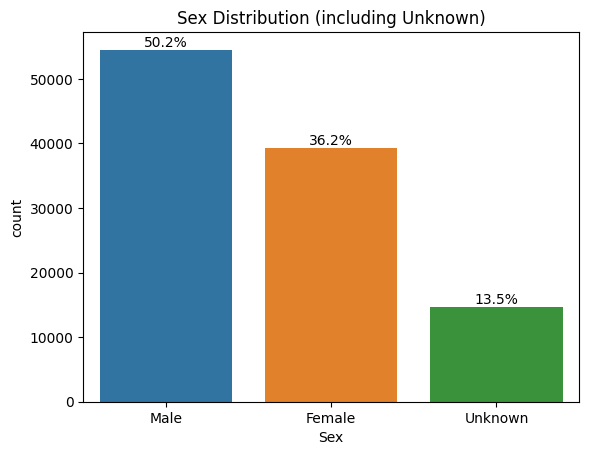

In [17]:
# Sex Dist
sex_for_count = train['Sex'].fillna('Unknown')

print('Distribution among train data of:',sex_for_count.value_counts())  # balanced ratio of Sex

ax = sns.countplot(x=sex_for_count)
total = len(train)
for p in ax.patches:
    count = p.get_height()
    perc = f'{100*count/total:.1f}%'
    ax.annotate(perc, (p.get_x() + p.get_width() / 2., count),
                ha='center', va='bottom', fontsize=10, color='black')
    
plt.title('Sex Distribution (including Unknown)')
plt.savefig('/content/sex_distribution.jpg')
plt.show()

/tmp/ipykernel_102/4182579387.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  condition_count_perAgeGroup = train.groupby('Age_Group')[label_cols].apply(lambda x: (x==1).sum() )


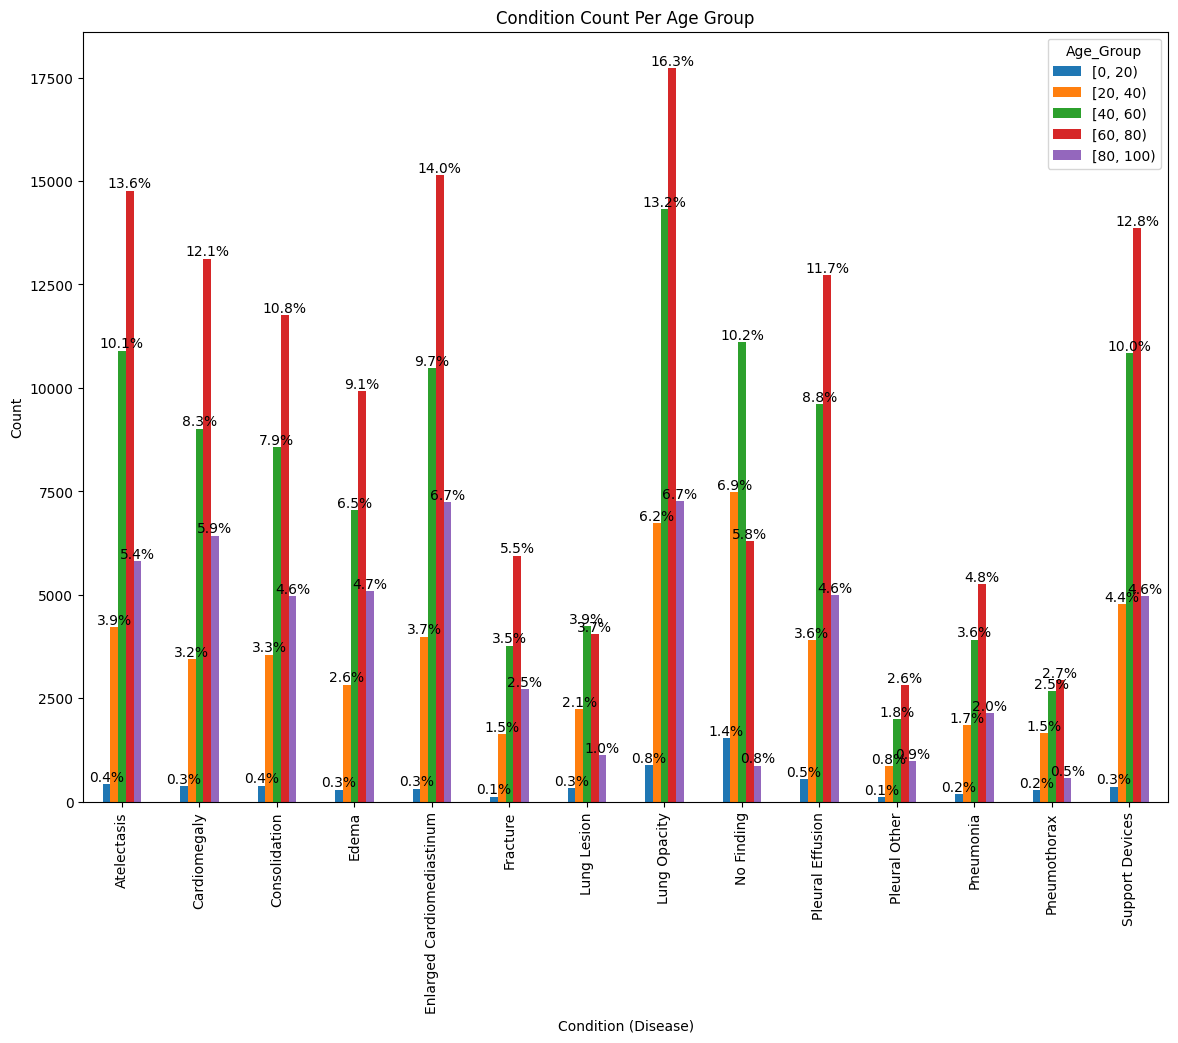

In [18]:
# Condition Count by Age group
age_bins = [0, 20, 40, 60, 80, 100]
# pd.cut() → makes age bins
train['Age_Group'] = pd.cut(train['Age'], bins = age_bins, right = False)
# counts of each condition by age group.
condition_count_perAgeGroup = train.groupby('Age_Group')[label_cols].apply(lambda x: (x==1).sum() )

ax = condition_count_perAgeGroup.T.plot(kind='bar',stacked=False,figsize=(14,10))
# The percentage label above each bar tells you the proportion of the entire dataset that falls into that (condition, age group) combination.
total = len(train)
for p in ax.patches:
    count = p.get_height()
    perc = f'{100*count/total:.1f}%'
    ax.annotate(perc, (p.get_x() + p.get_width() / 2., count),
                ha='center', va='bottom', fontsize=10, color='black')
    
plt.title('Condition Count Per Age Group')
plt.xlabel('Condition (Disease)')
plt.ylabel('Count')
plt.savefig('/content/condition_count_per_age_group.jpg')
plt.show()

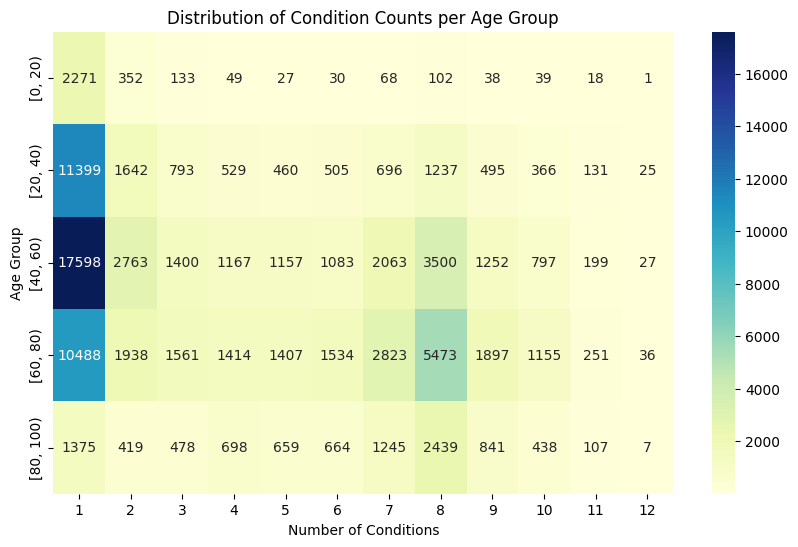

In [19]:
# Distribution of Multi-Labels per Age Group
# Cross-tabulate
age_condition_dist = pd.crosstab(train["Age_Group"], train["label_count"])

plt.figure(figsize=(10,6))
sns.heatmap(age_condition_dist, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Distribution of Condition Counts per Age Group")
plt.xlabel("Number of Conditions")
plt.ylabel("Age Group")
plt.show()


# Image View Breakdown

In [ ]:
train.head()

,Image_name,Patient_ID,Study,Sex,Age,ViewCategory,ViewPosition,Atelectasis,Cardiomegaly,Consolidation,...,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices,filepath,label_count,Age_Group
0,00000003_001_001.jpg,3,1,Male,41.0,Frontal,AP,0,1,0,...,1,0,0,0,0,0,0,/kaggle/input/grand-xray-slam-division-b/train...,4,"[40, 60)"
1,00000004_001_001.jpg,4,1,Female,20.0,Frontal,PA,0,0,0,...,0,1,0,0,0,0,0,/kaggle/input/grand-xray-slam-division-b/train...,1,"[20, 40)"
2,00000004_001_002.jpg,4,1,Female,20.0,Lateral,Lateral,0,0,0,...,0,1,0,0,0,0,0,/kaggle/input/grand-xray-slam-division-b/train...,1,"[20, 40)"
3,00000006_001_001.jpg,6,1,Female,42.0,Frontal,AP,0,0,0,...,0,1,0,0,0,0,0,/kaggle/input/grand-xray-slam-division-b/train...,1,"[40, 60)"
4,00000010_001_001.jpg,10,1,Female,50.0,Frontal,PA,0,0,0,...,0,1,0,0,0,0,0,/kaggle/input/grand-xray-slam-division-b/train...,1,"[40, 60)"


Unique Image View Categories:{'Lateral', 'Frontal'}


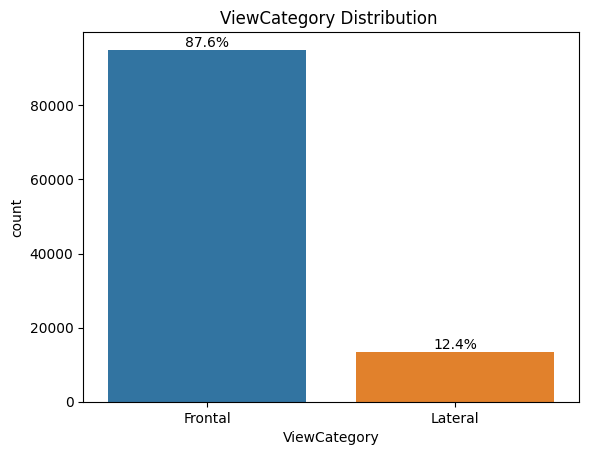

In [21]:
# ViewCategory 
print(f'Unique Image View Categories:{set(train["ViewCategory"])}')
ax = sns.countplot(x=train['ViewCategory'])

total = len(train)
for p in ax.patches:
    count = p.get_height()
    perc = f'{100*count/total:.1f}%'
    ax.annotate(perc, (p.get_x() + p.get_width() / 2., count),
                ha='center', va='bottom', fontsize=10, color='black')

plt.title('ViewCategory Distribution ')
plt.show()
# ViewCategory feature is inbalanced; More commonly to have ViewCateogry = Frontal images


Unique Image View Positions:{'PA', 'Lateral', 'LL', 'AP'}


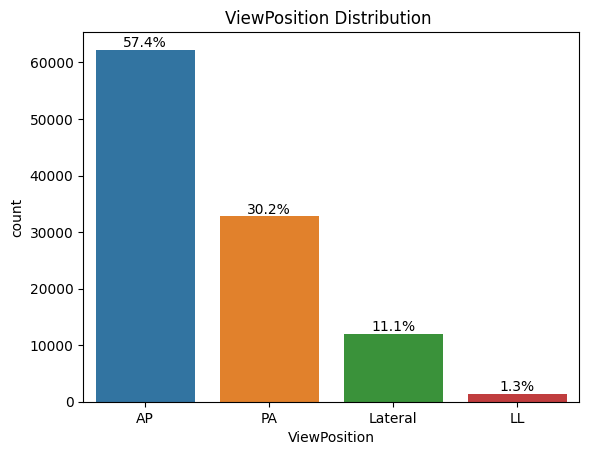

In [22]:
# ViewPosition
print(f'Unique Image View Positions:{set(train["ViewPosition"])}')
ax = sns.countplot(x=train['ViewPosition'])

total = len(train)
for p in ax.patches:
    count = p.get_height()
    perc = f'{100*count/total:.1f}%'
    ax.annotate(perc, (p.get_x() + p.get_width() / 2., count),
                ha='center', va='bottom', fontsize=10, color='black')
plt.title('ViewPosition Distribution ')
plt.show()
# Rare ViewPosition= LL , Commone ViewPosition=AP

# Visual Exploration
- First map the images files to the train.csv metadata so we have a filepath linked to each image data.
- visualize some of the Xray images

In [23]:
# Add full path to each image (new column:filepath )
train["filepath"] = train["Image_name"].apply(lambda x: os.path.join(data_dir, "train2", x))
train.head()

,Image_name,Patient_ID,Study,Sex,Age,ViewCategory,ViewPosition,Atelectasis,Cardiomegaly,Consolidation,...,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices,filepath,label_count,Age_Group
0,00000003_001_001.jpg,3,1,Male,41.0,Frontal,AP,0,1,0,...,1,0,0,0,0,0,0,/kaggle/input/grand-xray-slam-division-b/train...,4,"[40, 60)"
1,00000004_001_001.jpg,4,1,Female,20.0,Frontal,PA,0,0,0,...,0,1,0,0,0,0,0,/kaggle/input/grand-xray-slam-division-b/train...,1,"[20, 40)"
2,00000004_001_002.jpg,4,1,Female,20.0,Lateral,Lateral,0,0,0,...,0,1,0,0,0,0,0,/kaggle/input/grand-xray-slam-division-b/train...,1,"[20, 40)"
3,00000006_001_001.jpg,6,1,Female,42.0,Frontal,AP,0,0,0,...,0,1,0,0,0,0,0,/kaggle/input/grand-xray-slam-division-b/train...,1,"[40, 60)"
4,00000010_001_001.jpg,10,1,Female,50.0,Frontal,PA,0,0,0,...,0,1,0,0,0,0,0,/kaggle/input/grand-xray-slam-division-b/train...,1,"[40, 60)"


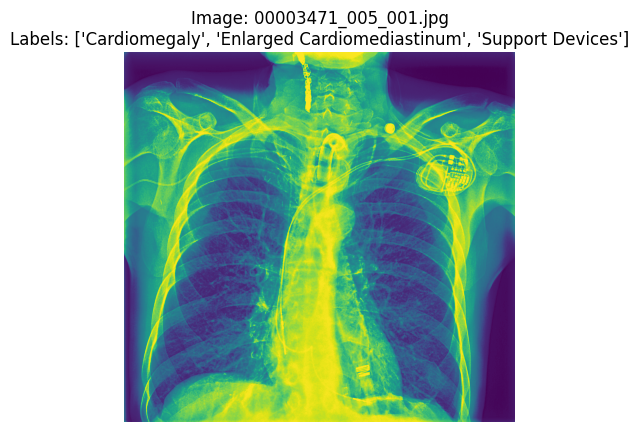

In [24]:
# Display an image with labels
# pick a random image
idx = random.randint(0,len(train)-1)
img_path = train.iloc[idx]['filepath']  # filepath mapping to the Xray
labels = train.iloc[idx][label_cols]   # conditions that this image have (will change each time this code is rerun)

# Show the image
img = mpimg.imread(img_path)  # loads image as numpy array
plt.imshow(img)
plt.title(f"Image: {train.iloc[idx]['Image_name']}\nLabels: {list(labels[labels==1].index)}")
plt.axis('off')
plt.show()

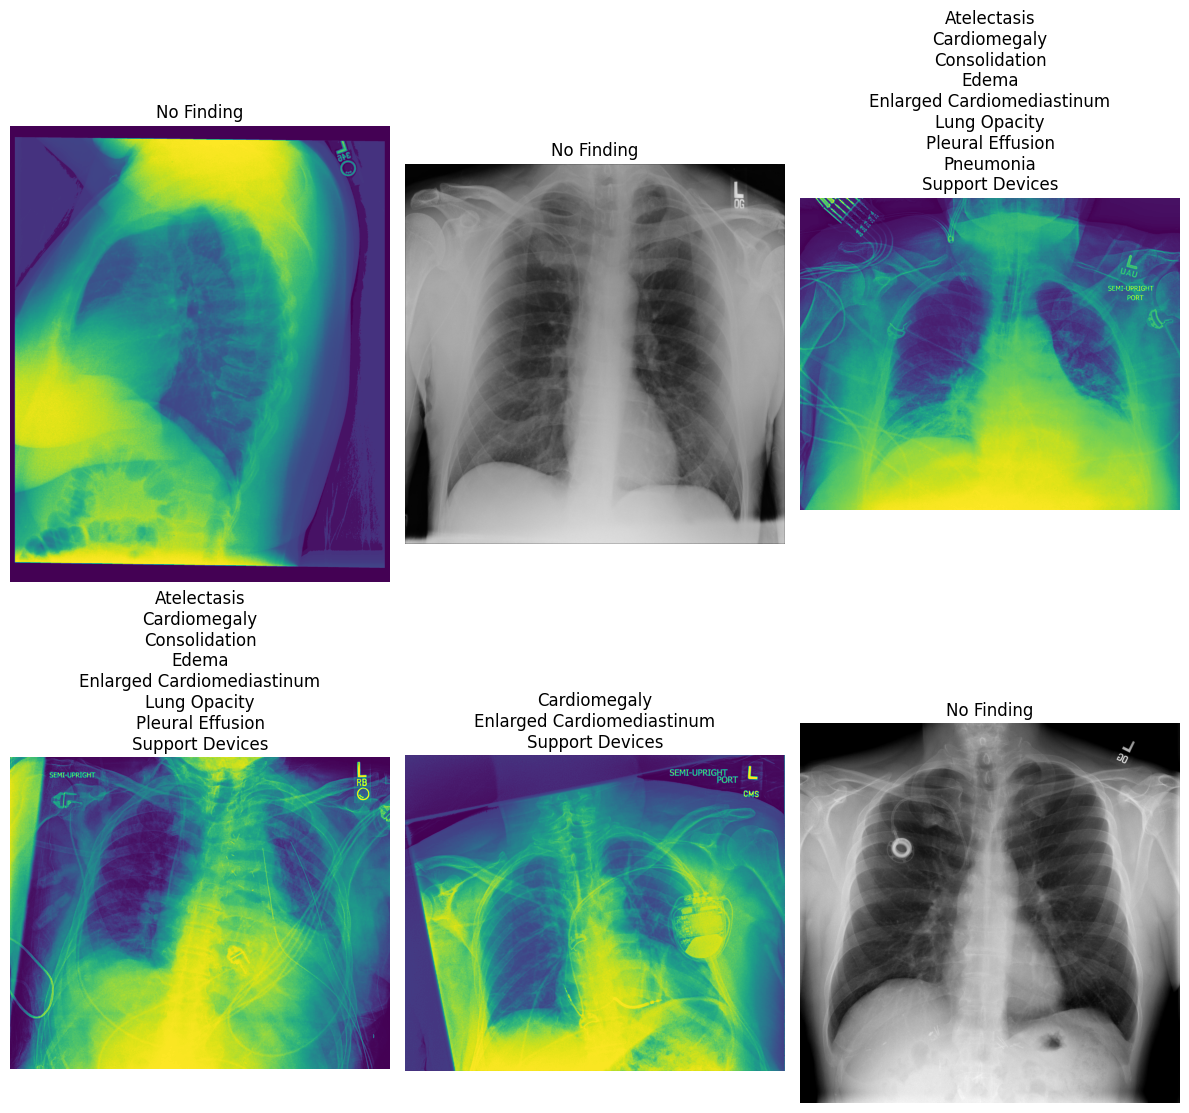

In [25]:
# scan through different X-rays and directly see the multi-label conditions
# Display 6 images
fig, axes = plt.subplots(2,3, figsize=(12,12))
for ax in axes.ravel():
    idx = random.randint(0, len(train)-1)
    img_path = train.iloc[idx]['filepath']
    img = mpimg.imread(img_path)

    # get labels
    labels = train.iloc[idx][label_cols]
    conditions = [c for c, v in labels.items() if v == 1]  #grab conditions that are positve in labels

    ax.imshow(img)
    ax.set_title("\n".join(conditions))
    ax.axis('off')
plt.tight_layout()
plt.show()

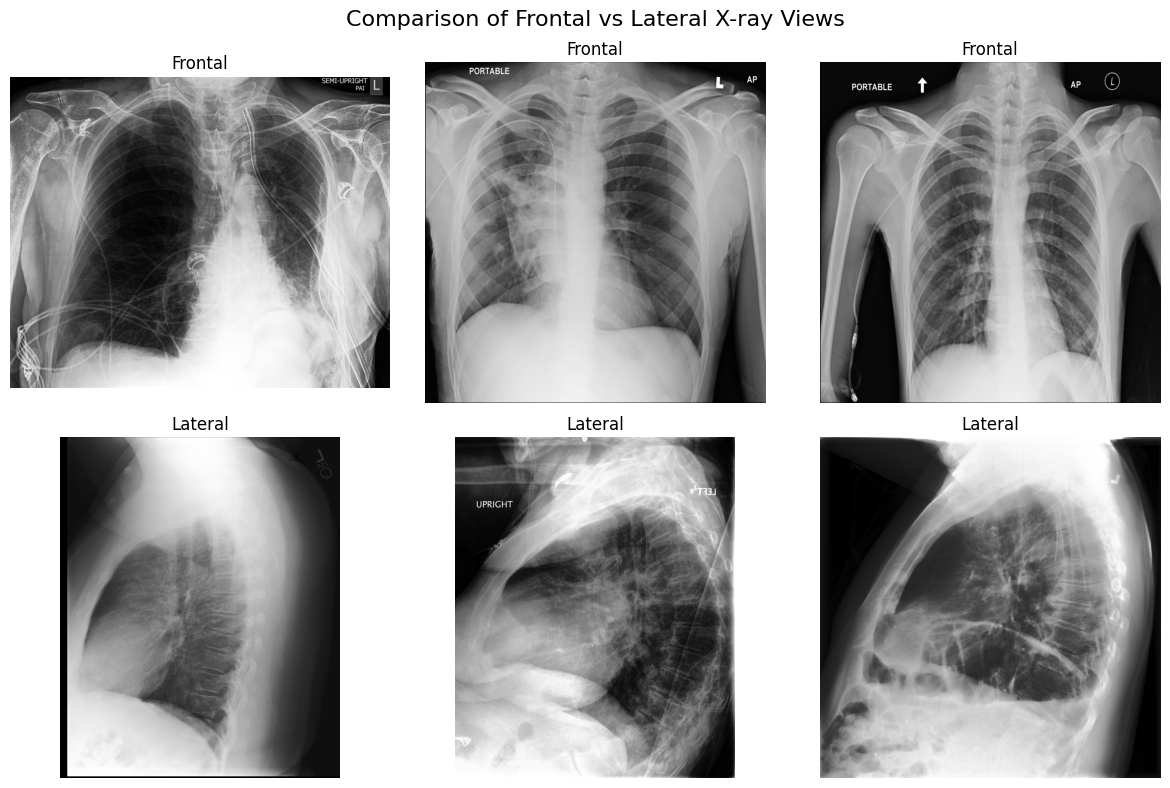

In [26]:
# Separate frontal and lateral filepaths
frontal_imgs = train[train['ViewCategory'] == 'Frontal']['filepath'].tolist()
lateral_imgs = train[train['ViewCategory'] == 'Lateral']['filepath'].tolist()

# Pick random samples
sample_frontal = random.sample(frontal_imgs, 3)
sample_lateral = random.sample(lateral_imgs, 3)

# Plot
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, fp in enumerate(sample_frontal):
    axes[0, i].imshow(mpimg.imread(fp), cmap='gray')
    axes[0, i].set_title("Frontal")
    axes[0, i].axis("off")

for i, fp in enumerate(sample_lateral):
    axes[1, i].imshow(mpimg.imread(fp), cmap='gray')
    axes[1, i].set_title("Lateral")
    axes[1, i].axis("off")

plt.suptitle("Comparison of Frontal vs Lateral X-ray Views", fontsize=16)
plt.tight_layout()
plt.show()

# Data Integrity Checks
- Verify uniqueness of Patient_IDs and Image_Names and check for metadate inconsistenicies

In [27]:
# check for image duplication 
dup_imgs = train['Image_name'].duplicated().sum()
print('Count of duplicated image entries:', dup_imgs)

# check for Patient_IDS duplicates
duplicated_patients = len(train) - train['Patient_ID'].nunique() # total_imgs - total_patients
print('Duplicated Patient_ID entries: ',dup_PatientIDs)

# invalid Age values
invalid_ages = train['Age'].dropna()
invalid_ages = invalid_ages[invalid_ages < 0].count()
print('Invalid Age values (<0):', invalid_ages)

Count of duplicated image entries: 0


NameError: name 'dup_PatientIDs' is not defined

In [ ]:
train.head(2)

# Key Findings
- **Dataset Size** 108,494 images, 32,077 total patients, and 184 studies
- **Label Imbalance**: Lung Opacity (45.18%), Atelectasis (35.59%) are dominant conditions; Pleural Other (6.39%) and Pneumothorax (8.05%) are rare.
- **Mulit-Label Complexity**: ~75% of images have muliple poisitive labels, requiring multi-label modeling.
- **Demogrphics**: Sex distribution balancd (~50% male/female ratio, assumed), Age distribution is normal with median Age ~50. Use Sex/Age as features.
- **Image Views:** Frontal ViewCategory views are dominant (>80%), as well as ViewPositions: AP, PA, and Lateral. Stratify by view for better performance.
  
- **Recommendations:**
1. Use weighted loss functions (e.g., binary cross-entropy with class weights) to address imbalance.
2. Apply data augmentation (e.g., rotation, flipping) for rare conditions like Pneumothorax.
3. Leverage multi-label techniques (e.g., sigmoid outputs per class).
Explore view-specific models or use ViewCategory/ViewPosition as features.

**Quick Intuition Before the Code**
- CNN (Convolutional Neural Network): Special kind of neural network that “looks” at images, learns edges → shapes → patterns → diseases.
- ResNet50: A popular CNN already trained on millions of images (ImageNet). We reuse its “vision power” and just adjust the last layer for our medical labels.
- Sigmoid: Converts raw numbers into probabilities between 0 and 1. Since each X-ray can have many conditions, we apply sigmoid separately for each label (multi-label setup).
- Binary Cross-Entropy Loss: Tells the model how wrong its predictions are for each label (disease vs. no disease).
Optimizer (Adam): Algorithm that updates the model’s weights to make predictions better step by step.

# Machine Learning Models
- First, train using a baseline model **(CNN: Transfer Learning)**
    - Use **stratified sampling** in train/validation splits (by label counts)
    - Try **class weighting** to give more importance to rare classes
    - consider oversampling rare-label images.
    - train with **binary cross entropy loss** (per label)
    - add a final **sigmoid layer** (14 outputs) for multi-label classification
    - 75% of images have multiple conditions, so treat as multi-label not mulit-class problem
    - East Label is independant, so output layer = vector of 14 probabilities
    - Use threshold tuning (eg 0.5 or optimize per label) for predictions.
    - Incorporate Metadata **(Age, Sex, View)**, they provide useful priors (eg older patients->more lung opacity)
    - Start with images only (baseline), laster add tabular features **Age, Sex, Views** in a parallet branch of the network.
Evaluation:
- Use macro ROC-AUC accross all 14 conditions as primary metric
- report per label ROC-AUC to see which conditions are hardest.

In [48]:
# Mult-Label Classification Baseline
# imports
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
import cv2
# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import warnings
warnings.filterwarnings('ignore')

In [49]:
# 0. Split into train and validation (80/20), ----Better to Mult-label stratified split instead of just stratify label_count
train_df , val_df = train_test_split(train, test_size=0.2, random_state=42, stratify=train['label_count'])

print('Train1.csv has rows:', len(train))
print('Train samples:', len(train_df)," Validation samples:", len(val_df) )

Train1.csv has rows: 108494
Train samples: 86795  Validation samples: 21699


**Data Generator**

In [50]:
# 2. Data Generator
# Custom data generator for images
class ChestXRayGenerator(Sequence):
    '''Custome generator for multi-label chest Xray dataset.
    Loads images from disk in batches, resizes, normalizes, and yields(X,y).
    Compatible with keras .fit() method'''
    def __init__(self, df, batch_size=32, img_size=(128, 128), is_test=False):
        self.df = df
        self.batch_size = batch_size
        self.img_size = img_size
        self.is_test = is_test
        self.label_cols = label_cols
        # picl correct folder depending on train vs test 
        self.image_dir = '/kaggle/input/grand-xray-slam-division-b/train2/' if not is_test else '/kaggle/input/grand-xray-slam-division-b/test2/'

        if not os.path.exists(self.image_dir):
            raise FileNotFoundError(f"Directory {self.image_dir} missing.")

    def __len__(self):
        # number of batches per epoch; 
        # ex: 1000imgs, batchsize=128: (1000 + 128 - 1) // 128 = 8 batches.
        return (len(self.df) + self.batch_size - 1) // self.batch_size

    def __getitem__(self, idx):
        # get batch indices
        # For batch idx, it selects only a slice of your dataframe 
        # (e.g., rows 0–127, then 128–255, …)
        start_idx = idx * self.batch_size
        end_idx = min(start_idx + self.batch_size, len(self.df))
        batch = self.df.iloc[start_idx:end_idx]
        
        images = []
        labels = []

        for _, row in batch.iterrows():
            # img loading
            img_path = os.path.join(self.image_dir, row['Image_name'])
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # make all imgs greyscale
            
            # Skip corrupted files instead of using zero arrays
            if img is None or img.shape[0] == 0 or img.shape[1] == 0:
                continue
            # Resize, normalize, expand dims to (H,W,1)
            img = cv2.resize(img, self.img_size)      # resize img to target size (128x128)
            img = img / 255.0                         # normalize pixel vals
            img = np.expand_dims(img, axis=-1)        # add an extra channel dimension -> shape becomes (H,W,1) for greyscale
            images.append(img)                        # append processed img
            
            # collect labels only for training mode
            if not self.is_test:
                labels.append(row[self.label_cols].values.astype(np.float32))

        # Handle edge case of no valid images in batch
        if len(images) == 0:
            images = [np.zeros((*self.img_size, 1), dtype=np.float32)]
            if not self.is_test:
                labels = [np.zeros(len(self.label_cols), dtype=np.float32)]

        images = np.array(images, dtype=np.float32)  #convert list of imgs->nparray
        # if its training/val (not test mode), also return labels
        if not self.is_test:
            labels = np.array(labels, dtype=np.float32) #convert list of labels into numpy array
            return images, labels
        return images

# Create generators
batch_size = 128
try:
    train_generator = ChestXRayGenerator(train_df, batch_size=batch_size)
    val_generator = ChestXRayGenerator(val_df, batch_size=batch_size)
    print("Train and validation generators created successfully.")
except Exception as e:
    print(f"Error creating generators: {e}")
    raise

Train and validation generators created successfully.


**Build CNN Model**

In [53]:
# Build simple CNN model
def create_cnn_model(input_shape=(128, 128, 1), num_classes=14):
    model = Sequential([
        # Conv2D + ReLu + MaxPooling
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'), # increase filters 32->64->128
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        # Flatten → Dense(128, relu) → learns combinations of features.
        Flatten(),             #turns the 2D feature maps into a 1D vector.
        Dense(128, activation='relu'),     # a fully connected layer
        Dropout(0.5),                       # prevents overfilling
        Dense(num_classes, activation='sigmoid')  # Sigmoid for multi-label for each 14 independant conditiosn
    ])
    return model

# Create and compile model
model = create_cnn_model()
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['AUC']
)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,870 (12.61 MB)

 Trainable params: 3,305,870 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
# 4. -------Train Model--------
history = model.fit(
    train_generator,
    validation_data = val_generator,  # validation data
    epochs = 1 #baseline: 1 epoch
)
# Print validation AUC-ROC
val_auc = history.history['val_AUC'][-1] if 'val_AUC' in history.history else 0.0
print(f"Validation AUC-ROC: {val_auc:.4f}")

679/679 ━━━━━━━━━━━━━━━━━━━━ 5499s 8s/step - AUC: 0.7944 - loss: 0.4483 - val_AUC: 0.8832 - val_loss: 0.3573
Validation AUC-ROC: 0.8832
